# PathForge – Career Intelligence System for East Africa

**Research-Grade Analytical Engine**

---

## System Overview

This notebook implements a comprehensive career intelligence system that:

1. **Aligns** career skill requirements with university program offerings
2. **Analyzes** skill gaps between student profiles and career requirements
3. **Computes** career similarity metrics for pathway exploration
4. **Scores** student readiness through project simulation
5. **Provides** explainable recommendations with sensitivity analysis

### Data Sources

Within the **Datasets** directory, you can find :
- `career_skills.csv`: Career skill requirements with weighted importance
- `university_programs_skills.csv`: University program skill coverage scores

### Methodology

The system uses vector-based skill representation with weighted alignment scoring to match students with optimal career-university combinations across East African institutions.

---

## 1. System Initialization

### Import Dependencies and Configure Environment

In [35]:
# Core data manipulation and numerical computing
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
import warnings

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning and similarity metrics
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr, spearmanr

# System utilities
import json
from typing import Dict, List, Tuple, Optional, Union


In [36]:
# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.precision', 4)
pd.set_option('display.width', 120)

# Set reproducibility seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Plotting configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ System initialized successfully")
print(f"  NumPy version: {np.__version__}")
print(f"  Pandas version: {pd.__version__}")
print(f"  Random seed: {RANDOM_SEED}")

✓ System initialized successfully
  NumPy version: 1.26.4
  Pandas version: 2.3.0+4.g1dfc98e16a
  Random seed: 42


### Define Reusable Utility Functions

Comprises of the most recurring & utility functions used all throughout the notebook

In [37]:
def normalize_text(text: str) -> str:
    """Normalize text for consistent matching."""
    if pd.isna(text):
        return ""
    return str(text).strip().lower()

def validate_range(df: pd.DataFrame, column: str, min_val: float, max_val: float, 
                   name: str = "value") -> Tuple[bool, str]:
    """Validate that column values fall within expected range."""
    invalid = df[(df[column] < min_val) | (df[column] > max_val)]
    if len(invalid) > 0:
        return False, f"Found {len(invalid)} {name}s outside range [{min_val}, {max_val}]"
    return True, f"All {name}s within valid range"

def compute_weighted_score(weights: np.ndarray, values: np.ndarray) -> float:
    """Compute weighted average score."""
    if len(weights) == 0 or np.sum(weights) == 0:
        return 0.0
    return np.sum(weights * values) / np.sum(weights)

def print_section_header(title: str, level: int = 1) -> None:
    """Print formatted section header."""
    symbols = {1: "=", 2: "-", 3: "·"}
    symbol = symbols.get(level, "-")
    print(f"\n{symbol * 80}")
    print(f"{title}")
    print(f"{symbol * 80}\n")

def summarize_dataframe(df: pd.DataFrame, name: str) -> None:
    """Print comprehensive DataFrame summary."""
    print(f"  {name}")
    print(f"   Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
    print(f"   Memory: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print(f"   Columns: {', '.join(df.columns.tolist())}")
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(f"   Missing values: {missing[missing > 0].to_dict()}")
    else:
        print(f"   Missing values: None")

print("✓ Utility functions defined")

✓ Utility functions defined


---

## 2. Data Loading & Validation Layer

Load datasets and perform validation checks.


In [38]:
# Load datasets
print_section_header("DATA LOADING", 1)

# Career skills data
career_skills_df = pd.read_csv('Datasets/career_skills.csv')
print("✓ Loaded career_skills.csv")
summarize_dataframe(career_skills_df, "Career Skills Dataset")

# University program coverage data
program_coverage_df = pd.read_csv('Datasets/university_programs_skills.csv')
print("\n✓ Loaded university_programs_skills.csv")
summarize_dataframe(program_coverage_df, "Program Coverage Dataset")

# Display sample records
print("\n  Sample Career Skills:")
display(career_skills_df.head(10))

print("\n  Sample Program Coverage:")
display(program_coverage_df.head(10))



DATA LOADING

✓ Loaded career_skills.csv
  Career Skills Dataset
   Shape: 1,120 rows × 5 columns
   Memory: 0.31 MB
   Columns: career_id, career_sector, career_name, skill_name, skill_weight
   Missing values: None

✓ Loaded university_programs_skills.csv
  Program Coverage Dataset
   Shape: 1,822 rows × 6 columns
   Memory: 0.64 MB
   Columns: program_id, program_name, university, region, skill_name, coverage_score
   Missing values: None

  Sample Career Skills:


,career_id,career_sector,career_name,skill_name,skill_weight
0,DA01,IT,Data Analyst,Python,0.90
1,DA01,IT,Data Analyst,SQL,0.90
2,DA01,IT,Data Analyst,Statistics,0.85
3,DA01,IT,Data Analyst,Data Cleaning,0.90
4,DA01,IT,Data Analyst,Exploratory Data Analysis,0.85
5,DA01,IT,Data Analyst,Data Visualization,0.85
6,DA01,IT,Data Analyst,Excel,0.80
7,DA01,IT,Data Analyst,Power BI,0.70
8,DA01,IT,Data Analyst,Tableau,0.70
9,DA01,IT,Data Analyst,Data Wrangling,0.80



  Sample Program Coverage:


,program_id,program_name,university,region,skill_name,coverage_score
0,P0001,BSc Computer Science,Kyambogo University,Uganda,HTML,0.53
1,P0001,BSc Computer Science,Kyambogo University,Uganda,CSS,0.74
2,P0001,BSc Computer Science,Kyambogo University,Uganda,JavaScript,0.71
3,P0001,BSc Computer Science,Kyambogo University,Uganda,React,0.48
4,P0001,BSc Computer Science,Kyambogo University,Uganda,Node.js,0.58
5,P0001,BSc Computer Science,Kyambogo University,Uganda,Express.js,0.71
6,P0001,BSc Computer Science,Kyambogo University,Uganda,REST APIs,0.59
7,P0001,BSc Computer Science,Kyambogo University,Uganda,Database Design,0.74
8,P0001,BSc Computer Science,Kyambogo University,Uganda,SQL,0.78
9,P0001,BSc Computer Science,Kyambogo University,Uganda,Authentication,0.64


### Schema Validation


In [39]:
print_section_header("SCHEMA VALIDATION", 2)

# Expected schemas
expected_career_cols = ['career_id', 'career_sector', 'career_name', 'skill_name', 'skill_weight']
expected_program_cols = ['program_id', 'program_name', 'university', 'region', 'skill_name', 'coverage_score']

# Validate career skills schema
career_cols_match = set(career_skills_df.columns) == set(expected_career_cols)
assert career_cols_match, f"Career skills schema mismatch"
print("✓ Career skills schema valid")

# Validate program coverage schema
program_cols_match = set(program_coverage_df.columns) == set(expected_program_cols)
assert program_cols_match, f"Program coverage schema mismatch"
print("✓ Program coverage schema valid")

# Check data types
assert pd.api.types.is_numeric_dtype(career_skills_df['skill_weight']), "skill_weight must be numeric"
assert pd.api.types.is_numeric_dtype(program_coverage_df['coverage_score']), "coverage_score must be numeric"
print("✓ Data types valid")



--------------------------------------------------------------------------------
SCHEMA VALIDATION
--------------------------------------------------------------------------------

✓ Career skills schema valid
✓ Program coverage schema valid
✓ Data types valid


### Data Quality Validation


In [40]:
print_section_header("DATA QUALITY VALIDATION", 2)

# Check for missing values
career_missing = career_skills_df.isnull().sum()
program_missing = program_coverage_df.isnull().sum()

assert career_missing.sum() == 0, f"Found missing values in career_skills"
assert program_missing.sum() == 0, f"Found missing values in program_coverage"
print("✓ No missing values detected")

# Validate skill_weight range [0.5, 0.95]
is_valid, msg = validate_range(career_skills_df, 'skill_weight', 0.5, 0.95, 'skill weight')
print(f"✓ {msg}" if is_valid else f"⚠ Warning: {msg}")

# Validate coverage_score range [0, 1]
is_valid, msg = validate_range(program_coverage_df, 'coverage_score', 0.0, 1.0, 'coverage score')
print(f"✓ {msg}" if is_valid else f"⚠ Warning: {msg}")

# Validate each career has >= 20 skills
skills_per_career = career_skills_df.groupby('career_name').size()
careers_below_threshold = skills_per_career[skills_per_career < 20]

if len(careers_below_threshold) > 0:
    print(f"\n⚠ Warning: {len(careers_below_threshold)} careers have < 20 skills")
else:
    print(f"\n✓ All careers have >= 20 skills (min: {skills_per_career.min()}, max: {skills_per_career.max()})")

# Statistical summary
print("\nStatistical Summary:")
print("\nCareer Skills:")
print(career_skills_df['skill_weight'].describe())
print("\nProgram Coverage:")
print(program_coverage_df['coverage_score'].describe())



--------------------------------------------------------------------------------
DATA QUALITY VALIDATION
--------------------------------------------------------------------------------

✓ No missing values detected
✓ All skill weights within valid range
✓ All coverage scores within valid range

⚠ Warning: 15 careers have < 20 skills

Statistical Summary:

Career Skills:
count    1120.0000
mean        0.8642
std         0.0512
min         0.6500
25%         0.8500
50%         0.8500
75%         0.9000
max         0.9500
Name: skill_weight, dtype: float64

Program Coverage:
count    1822.0000
mean        0.6874
std         0.1084
min         0.4600
25%         0.6000
50%         0.7000
75%         0.7700
max         0.8900
Name: coverage_score, dtype: float64


### Data Consistency Checks


In [41]:
print_section_header("DATA CONSISTENCY CHECKS", 2)

# Check for duplicate records
career_dupes = career_skills_df.duplicated(subset=['career_name', 'skill_name']).sum()
program_dupes = program_coverage_df.duplicated(subset=['program_id', 'skill_name']).sum()

print(f"Duplicate career-skill combinations: {career_dupes}")
print(f"Duplicate program-skill combinations: {program_dupes}")

# Count unique entities
print("\n  Entity Counts:")
print(f"   Unique careers: {career_skills_df['career_name'].nunique()}")
print(f"   Unique career IDs: {career_skills_df['career_id'].nunique()}")
print(f"   Unique sectors: {career_skills_df['career_sector'].nunique()}")
print(f"   Unique skills (career data): {career_skills_df['skill_name'].nunique()}")
print(f"\n   Unique programs: {program_coverage_df['program_name'].nunique()}")
print(f"   Unique universities: {program_coverage_df['university'].nunique()}")
print(f"   Unique regions: {program_coverage_df['region'].nunique()}")
print(f"   Unique skills (program data): {program_coverage_df['skill_name'].nunique()}")

# Sector distribution
print("\n  Sector Distribution:")
sector_dist = career_skills_df.groupby('career_sector')['career_name'].nunique()
print(sector_dist.to_string())

# Region distribution
print("\n  Region Distribution:")
region_dist = program_coverage_df.groupby('region')['program_id'].nunique()
print(region_dist.to_string())

print("\n✓ Data consistency validation complete")



--------------------------------------------------------------------------------
DATA CONSISTENCY CHECKS
--------------------------------------------------------------------------------

Duplicate career-skill combinations: 0
Duplicate program-skill combinations: 0

  Entity Counts:
   Unique careers: 56
   Unique career IDs: 56
   Unique sectors: 3
   Unique skills (career data): 497

   Unique programs: 14
   Unique universities: 22
   Unique regions: 4
   Unique skills (program data): 213

  Sector Distribution:
career_sector
Business & Finance    15
Engineering           30
IT                    11

  Region Distribution:
region
Kenya       15
Rwanda      15
Tanzania    11
Uganda      14

✓ Data consistency validation complete


---

## 3. Data Cleaning & Skill Normalization

Standardize text fields and harmonize skill names across datasets.


In [42]:
print_section_header("DATA CLEANING & NORMALIZATION", 1)

# Create cleaned copies
career_clean = career_skills_df.copy()
program_clean = program_coverage_df.copy()

# Normalize text columns
print("Normalizing text fields...")
career_clean['career_name_clean'] = career_clean['career_name'].apply(normalize_text)
career_clean['skill_name_clean'] = career_clean['skill_name'].apply(normalize_text)
career_clean['career_sector_clean'] = career_clean['career_sector'].apply(normalize_text)

program_clean['program_name_clean'] = program_clean['program_name'].apply(normalize_text)
program_clean['university_clean'] = program_clean['university'].apply(normalize_text)
program_clean['skill_name_clean'] = program_clean['skill_name'].apply(normalize_text)
program_clean['region_clean'] = program_clean['region'].apply(normalize_text)

print("✓ Text normalization complete")

# Remove exact duplicates
career_before = len(career_clean)
program_before = len(program_clean)

career_clean = career_clean.drop_duplicates(subset=['career_name_clean', 'skill_name_clean'])
program_clean = program_clean.drop_duplicates(subset=['program_id', 'skill_name_clean'])

print(f"\nRemoved {career_before - len(career_clean)} duplicate career-skill records")
print(f"Removed {program_before - len(program_clean)} duplicate program-skill records")



DATA CLEANING & NORMALIZATION

Normalizing text fields...
✓ Text normalization complete

Removed 0 duplicate career-skill records
Removed 0 duplicate program-skill records


### Create Master Skill Dictionary

A unique dataset that tracks which skills appear in career data vs program data and counts the frequency of each skill


In [47]:
print_section_header("CREATING MASTER SKILL DICTIONARY", 2)

# Collect all unique skills
career_skills_set = set(career_clean['skill_name_clean'].unique())
program_skills_set = set(program_clean['skill_name_clean'].unique())
all_skills = sorted(career_skills_set.union(program_skills_set))

# Create skill dictionary with IDs
master_skills = pd.DataFrame({
    'skill_id': [f'SK{i:04d}' for i in range(1, len(all_skills) + 1)],
    'skill_name_normalized': all_skills,
    'in_career_data': [s in career_skills_set for s in all_skills],
    'in_program_data': [s in program_skills_set for s in all_skills]
})

# Add frequency counts
career_skill_counts = career_clean['skill_name_clean'].value_counts()
program_skill_counts = program_clean['skill_name_clean'].value_counts()

master_skills['career_frequency'] = master_skills['skill_name_normalized'].map(career_skill_counts).fillna(0).astype(int)
master_skills['program_frequency'] = master_skills['skill_name_normalized'].map(program_skill_counts).fillna(0).astype(int)

print(f"✓ Master skill dictionary created with {len(master_skills)} unique skills")
print(f"   Skills in career data only: {(master_skills['in_career_data'] & ~master_skills['in_program_data']).sum()}")
print(f"   Skills in program data only: {(~master_skills['in_career_data'] & master_skills['in_program_data']).sum()}")
print(f"   Skills in both datasets: {(master_skills['in_career_data'] & master_skills['in_program_data']).sum()}")

# Display sample
print("\n  Master Skill Dictionary (sample):")
display(master_skills.head(15))

# Map skill IDs
skill_to_id = dict(zip(master_skills['skill_name_normalized'], master_skills['skill_id']))
career_clean['skill_id'] = career_clean['skill_name_clean'].map(skill_to_id)
program_clean['skill_id'] = program_clean['skill_name_clean'].map(skill_to_id)

# Save
master_skills.to_csv('datasets/master_skill_dictionary.csv', index=False)
print("\n✓ Master skill dictionary saved")



--------------------------------------------------------------------------------
CREATING MASTER SKILL DICTIONARY
--------------------------------------------------------------------------------

✓ Master skill dictionary created with 497 unique skills
   Skills in career data only: 284
   Skills in program data only: 0
   Skills in both datasets: 213

  Master Skill Dictionary (sample):


,skill_id,skill_name_normalized,in_career_data,in_program_data,career_frequency,program_frequency
0,SK0001,3d mathematics,True,False,1,0
1,SK0002,accessibility standards,True,False,1,0
2,SK0003,accounting principles,True,True,3,11
3,SK0004,actuator systems,True,False,2,0
4,SK0005,adaptability,True,False,1,0
5,SK0006,aerodynamics,True,False,1,0
6,SK0007,air pollution control,True,True,1,3
7,SK0008,aircraft structures,True,False,1,0
8,SK0009,algorithms,True,False,1,0
9,SK0010,analog systems,True,False,1,0



✓ Master skill dictionary saved


---

## 4. Exploratory Data Analysis (EDA)

Comprehensive visual analysis of career requirements and program offerings to understand patterns in the data before modeling


### 4.1 Skill Weight Distribution Analysis

Comprises of : 
* Histograms showing how skill importance is distributed
* Comparison across sectors (IT, Business, Engineering)
* Box plots showing variance by sector



SKILL WEIGHT DISTRIBUTION



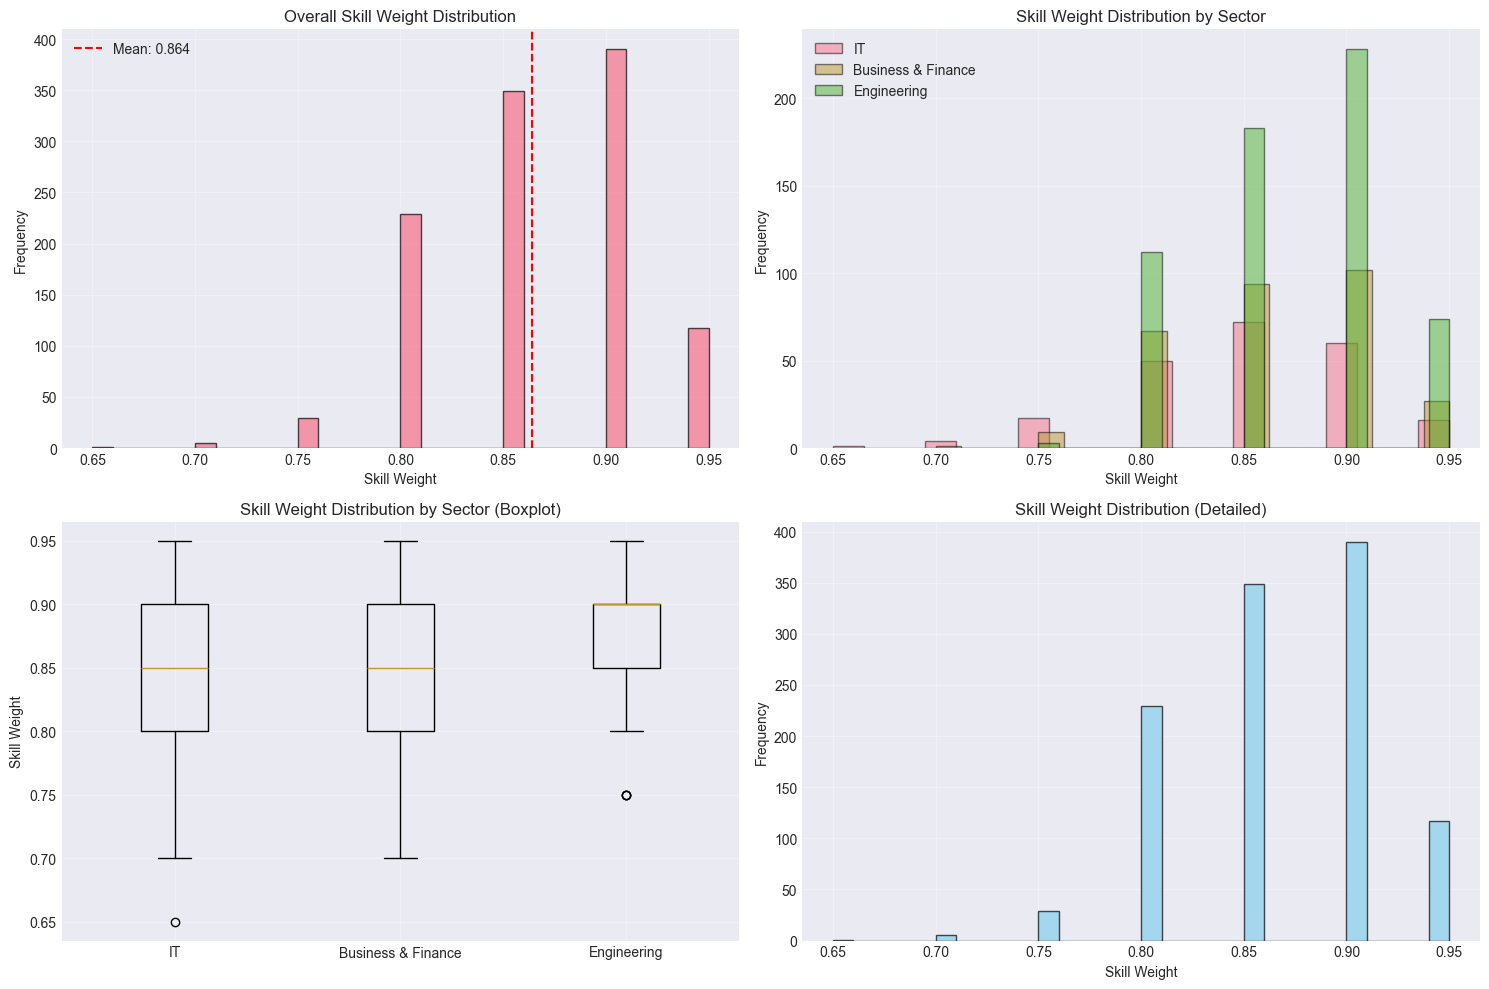


  Skill Weight Statistics by Sector:


,count,mean,std,min,25%,50%,75%,max
career_sector,,,,,,,,
Business & Finance,300.0,0.8613,0.0506,0.70,0.80,0.85,0.9,0.95
Engineering,600.0,0.8715,0.0473,0.75,0.85,0.90,0.9,0.95
IT,220.0,0.8482,0.0579,0.65,0.80,0.85,0.9,0.95


In [71]:
print_section_header("SKILL WEIGHT DISTRIBUTION", 1)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Overall distribution
axes[0, 0].hist(career_clean['skill_weight'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(career_clean['skill_weight'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {career_clean["skill_weight"].mean():.3f}')
axes[0, 0].set_xlabel('Skill Weight')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Overall Skill Weight Distribution')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Distribution by sector
sectors = career_clean['career_sector'].unique()
for sector in sectors:
    sector_data = career_clean[career_clean['career_sector'] == sector]['skill_weight']
    axes[0, 1].hist(sector_data, bins=20, alpha=0.5, label=sector, edgecolor='black')

axes[0, 1].set_xlabel('Skill Weight')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Skill Weight Distribution by Sector')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Box plot by sector
sector_data_list = [career_clean[career_clean['career_sector'] == s]['skill_weight'].values for s in sectors]
axes[1, 0].boxplot(sector_data_list, labels=sectors)
axes[1, 0].set_ylabel('Skill Weight')
axes[1, 0].set_title('Skill Weight Distribution by Sector (Boxplot)')
axes[1, 0].grid(alpha=0.3)

# Histogram with stats
axes[1, 1].hist(career_clean['skill_weight'], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
axes[1, 1].set_xlabel('Skill Weight')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Skill Weight Distribution (Detailed)')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('Diagrams/skill_weight_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Statistical summary
print("\n  Skill Weight Statistics by Sector:")
weight_stats = career_clean.groupby('career_sector')['skill_weight'].describe()
display(weight_stats)


### 4.2 Skills per Career Analysis

Comprises of : 
* Bar charts of careers with most skills
* Distribution of skill count across all careers


--------------------------------------------------------------------------------
SKILLS PER CAREER ANALYSIS
--------------------------------------------------------------------------------



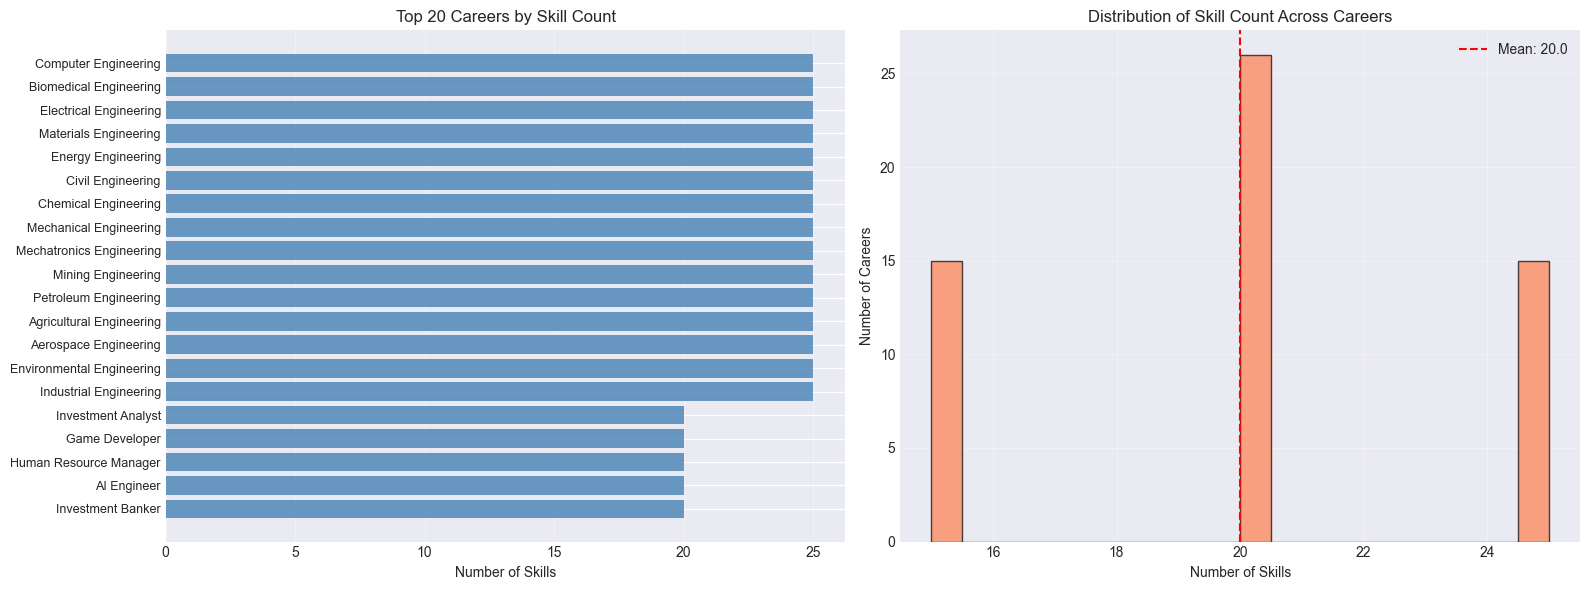


  Skills per Career Statistics:
   Mean: 20.00
   Median: 20
   Min: 15
   Max: 25


In [70]:
print_section_header("SKILLS PER CAREER ANALYSIS", 2)

# Count skills per career
skills_per_career = career_clean.groupby(['career_name', 'career_sector']).size().reset_index(name='skill_count')
skills_per_career = skills_per_career.sort_values('skill_count', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart of top careers
top_n = 20
top_careers = skills_per_career.head(top_n)

axes[0].barh(range(len(top_careers)), top_careers['skill_count'], color='steelblue', alpha=0.8)
axes[0].set_yticks(range(len(top_careers)))
axes[0].set_yticklabels(top_careers['career_name'], fontsize=9)
axes[0].set_xlabel('Number of Skills')
axes[0].set_title(f'Top {top_n} Careers by Skill Count')
axes[0].invert_yaxis()
axes[0].grid(alpha=0.3, axis='x')

# Distribution histogram
axes[1].hist(skills_per_career['skill_count'], bins=20, edgecolor='black', alpha=0.7, color='coral')
axes[1].axvline(skills_per_career['skill_count'].mean(), color='red', linestyle='--',
                label=f'Mean: {skills_per_career["skill_count"].mean():.1f}')
axes[1].set_xlabel('Number of Skills')
axes[1].set_ylabel('Number of Careers')
axes[1].set_title('Distribution of Skill Count Across Careers')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('Diagrams/skills_per_career.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary statistics
print("\n  Skills per Career Statistics:")
print(f"   Mean: {skills_per_career['skill_count'].mean():.2f}")
print(f"   Median: {skills_per_career['skill_count'].median():.0f}")
print(f"   Min: {skills_per_career['skill_count'].min()}")
print(f"   Max: {skills_per_career['skill_count'].max()}")


### 4.3 Program Coverage Distribution

Comprises of : 
* How well programs cover skills (overall distribution)
* Regional comparisons (Rwanda, Kenya, Uganda, Tanzania)
* Top programs by average coverage



--------------------------------------------------------------------------------
PROGRAM COVERAGE ANALYSIS
--------------------------------------------------------------------------------



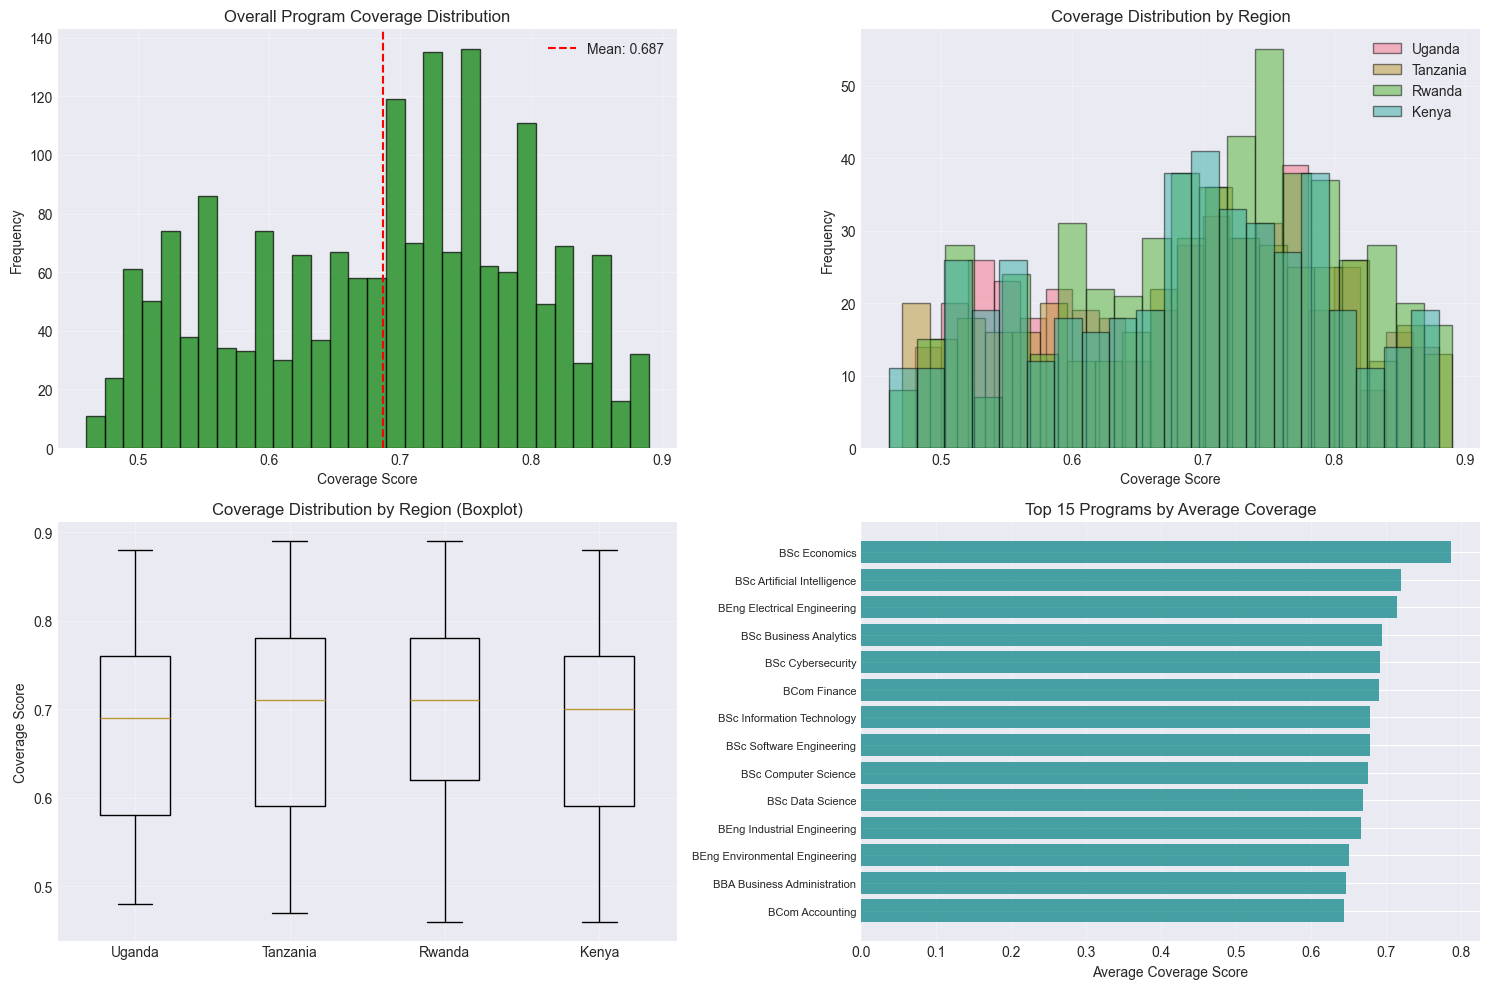


  Coverage Statistics by Region:


,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
Kenya,447.0,0.6823,0.1069,0.46,0.59,0.70,0.76,0.88
Rwanda,536.0,0.6987,0.1062,0.46,0.62,0.71,0.78,0.89
Tanzania,407.0,0.6896,0.1119,0.47,0.59,0.71,0.78,0.89
Uganda,432.0,0.6768,0.1081,0.48,0.58,0.69,0.76,0.88


In [69]:
print_section_header("PROGRAM COVERAGE ANALYSIS", 2)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Overall coverage distribution
axes[0, 0].hist(program_clean['coverage_score'], bins=30, edgecolor='black', alpha=0.7, color='green')
axes[0, 0].axvline(program_clean['coverage_score'].mean(), color='red', linestyle='--',
                   label=f'Mean: {program_clean["coverage_score"].mean():.3f}')
axes[0, 0].set_xlabel('Coverage Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Overall Program Coverage Distribution')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Coverage by region
regions = program_clean['region'].unique()
for region in regions:
    region_data = program_clean[program_clean['region'] == region]['coverage_score']
    axes[0, 1].hist(region_data, bins=20, alpha=0.5, label=region, edgecolor='black')

axes[0, 1].set_xlabel('Coverage Score')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Coverage Distribution by Region')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Box plot by region
region_data_list = [program_clean[program_clean['region'] == r]['coverage_score'].values for r in regions]
axes[1, 0].boxplot(region_data_list, labels=regions)
axes[1, 0].set_ylabel('Coverage Score')
axes[1, 0].set_title('Coverage Distribution by Region (Boxplot)')
axes[1, 0].grid(alpha=0.3)

# Average coverage by program
avg_coverage = program_clean.groupby('program_name')['coverage_score'].mean().sort_values(ascending=False).head(15)
axes[1, 1].barh(range(len(avg_coverage)), avg_coverage.values, color='teal', alpha=0.7)
axes[1, 1].set_yticks(range(len(avg_coverage)))
axes[1, 1].set_yticklabels(avg_coverage.index, fontsize=8)
axes[1, 1].set_xlabel('Average Coverage Score')
axes[1, 1].set_title('Top 15 Programs by Average Coverage')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('Diagrams/program_coverage_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n  Coverage Statistics by Region:")
coverage_stats = program_clean.groupby('region')['coverage_score'].describe()
display(coverage_stats)


---

## 5. Career Vectorization Engine

Transform career skill requirements into vector representation so that we can **enable mathematical operations on career requirement**


Vectorization Methodology:

We transform career skill requirements into vectors where:
- Each dimension represents a unique skill
- Values represent importance weight (0.5-0.95) or 0 if skill not required
- Enables mathematical operations like similarity and alignment

Benefits:
- Cosine similarity for career comparison
- Weighted alignment with programs
- Gap analysis through vector operations



In [52]:
print_section_header("CAREER VECTORIZATION", 1)

# Create career-skill matrix
print("\nCreating career-skill matrix...")

career_vector_matrix = career_clean.pivot_table(
    index='career_name',
    columns='skill_name_clean',
    values='skill_weight',
    fill_value=0.0
)

print(f"✓ Career vector matrix created")
print(f"   Shape: {career_vector_matrix.shape[0]} careers × {career_vector_matrix.shape[1]} skills")
print(f"   Sparsity: {(career_vector_matrix == 0).sum().sum() / career_vector_matrix.size * 100:.2f}%")

# Add metadata
career_metadata = career_clean[['career_name', 'career_id', 'career_sector']].drop_duplicates()
career_metadata = career_metadata.set_index('career_name')

# Compute statistics
career_vector_stats = pd.DataFrame({
    'career_id': career_metadata['career_id'],
    'career_sector': career_metadata['career_sector'],
    'total_skills': (career_vector_matrix > 0).sum(axis=1),
    'avg_weight': career_vector_matrix[career_vector_matrix > 0].mean(axis=1),
    'max_weight': career_vector_matrix.max(axis=1)
})

print("\n  Career Vector Statistics (sample):")
display(career_vector_stats.head(10))

print("\n✓ Career vectorization complete")



CAREER VECTORIZATION


Creating career-skill matrix...
✓ Career vector matrix created
   Shape: 56 careers × 497 skills
   Sparsity: 95.98%

  Career Vector Statistics (sample):


,career_id,career_sector,total_skills,avg_weight,max_weight
career_name,,,,,
AI Engineer,AI01,IT,20,0.8775,0.95
Accountant,AC01,Business & Finance,20,0.8475,0.95
Actuary,ACT01,Business & Finance,20,0.8675,0.95
Aerospace Engineering,AE01,Engineering,25,0.8840,0.95
Agricultural Engineering,AG01,Engineering,25,0.8460,0.95
Auditor,AU01,Business & Finance,20,0.8550,0.95
Automotive Engineering,AUTO01,Engineering,15,0.8767,0.95
Backend Developer,BE01,IT,20,0.8600,0.90
Biomedical Engineering,BME01,Engineering,25,0.8680,0.95



✓ Career vectorization complete


---

## 6. University Program Vectorizaton

Create program vectors aligned with career skill space to make programs comparable to careers mathematically by basically : 
- Aligning program vectors with career vectors
- Adding zero columns for skills programs don't teach
- Ensuring vectors have same dimensions for comparison


In [53]:
print_section_header("PROGRAM VECTORIZATION", 1)

# Create program-skill matrix
print("Creating program-skill matrix...")

# Create unique program identifier
program_clean['program_university'] = program_clean['program_name'] + ' @ ' + program_clean['university']

program_vector_matrix = program_clean.pivot_table(
    index='program_university',
    columns='skill_name_clean',
    values='coverage_score',
    aggfunc='mean',
    fill_value=0.0
)

print(f"✓ Program vector matrix created")
print(f"   Shape: {program_vector_matrix.shape[0]} programs × {program_vector_matrix.shape[1]} skills")

# Align with career skill space
print("\nAligning with career skill space...")

career_skills = career_vector_matrix.columns.tolist()
program_skills = program_vector_matrix.columns.tolist()

missing_in_programs = set(career_skills) - set(program_skills)
print(f"   Skills in career space: {len(career_skills)}")
print(f"   Skills in program space: {len(program_skills)}")
print(f"   Missing in programs: {len(missing_in_programs)}")

# Add missing skills as zero columns
for skill in missing_in_programs:
    program_vector_matrix[skill] = 0.0

# Reorder columns to match
program_vector_matrix_aligned = program_vector_matrix[career_skills]

print(f"\n✓ Program vectors aligned")
print(f"   Aligned shape: {program_vector_matrix_aligned.shape}")

# Add metadata
program_metadata = program_clean[['program_university', 'program_id', 'program_name', 'university', 'region']].drop_duplicates()
program_metadata = program_metadata.set_index('program_university')

# Statistics
program_vector_stats = pd.DataFrame({
    'program_id': program_metadata['program_id'],
    'program_name': program_metadata['program_name'],
    'university': program_metadata['university'],
    'region': program_metadata['region'],
    'total_skills_covered': (program_vector_matrix_aligned > 0).sum(axis=1),
    'avg_coverage': program_vector_matrix_aligned[program_vector_matrix_aligned > 0].mean(axis=1)
})

print("\n  Program Vector Statistics (sample):")
display(program_vector_stats.head(10))

print("\n✓ Program vectorization complete")



PROGRAM VECTORIZATION

Creating program-skill matrix...
✓ Program vector matrix created
   Shape: 55 programs × 213 skills

Aligning with career skill space...
   Skills in career space: 497
   Skills in program space: 213
   Missing in programs: 284

✓ Program vectors aligned
   Aligned shape: (55, 497)

  Program Vector Statistics (sample):


,program_id,program_name,university,region,total_skills_covered,avg_coverage
program_university,,,,,,
BBA Business Administration @ Moi University,P0026,BBA Business Administration,Moi University,Kenya,35,0.6331
BBA Business Administration @ Technical University of Kenya,P0027,BBA Business Administration,Technical University of Kenya,Kenya,35,0.6571
BBA Business Administration @ University of Kigali,P0025,BBA Business Administration,University of Kigali,Rwanda,35,0.6511
BCom Accounting @ Kenyatta University,P0029,BCom Accounting,Kenyatta University,Kenya,20,0.6285
BCom Accounting @ Moi University,P0030,BCom Accounting,Moi University,Kenya,20,0.6385
BCom Accounting @ United States International University Africa,P0028,BCom Accounting,United States International University Africa,Kenya,20,0.6650
BCom Finance @ AUCA (Adventist University of Central Africa),P0032,BCom Finance,AUCA (Adventist University of Central Africa),Rwanda,28,0.6500
BCom Finance @ Jomo Kenyatta University of Agriculture and Technology,P0035,BCom Finance,Jomo Kenyatta University of Agriculture and Te...,Kenya,28,0.7664
BCom Finance @ Kyambogo University,P0034,BCom Finance,Kyambogo University,Uganda,28,0.6382



✓ Program vectorization complete


---

## 7. Alignment Scoring Engine

Compute weighted alignment between careers and programs.


### 7.1 Alignment Formula and Implementation

Weighted Alignment Score Formula:

Alignment Score = Σ (career_skill_weight × program_coverage_score) / Σ (career_skill_weight)

Interpretation:
  - Score ∈ [0, 1]
  - 1.0: Perfect alignment (100% coverage)
  - 0.8: 80% weighted coverage
  - <0.5: Significant gaps

Properties:
  - Weights important skills higher
  - Normalized by total weight
  - Missing skills contribute 0


In [54]:
print_section_header("ALIGNMENT SCORING ENGINE", 1)

print("""

                    Σ (career_skill_weight × program_coverage_score)
  Alignment Score = ───────────────────────────────────────────────
                              Σ (career_skill_weight)

""")

def compute_alignment_score(career_vector: np.ndarray, program_vector: np.ndarray) -> float:
    """Compute weighted alignment score."""
    required_mask = career_vector > 0
    
    if required_mask.sum() == 0:
        return 0.0
    
    weights = career_vector[required_mask]
    coverage = program_vector[required_mask]
    
    numerator = np.sum(weights * coverage)
    denominator = np.sum(weights)
    
    return numerator / denominator if denominator > 0 else 0.0

def compute_alignment(career_name: str, country_filter: Optional[str] = None, top_n: int = 10) -> pd.DataFrame:
    """Compute alignment scores for all programs."""
    if career_name not in career_vector_matrix.index:
        raise ValueError(f"Career '{career_name}' not found")
    
    career_vec = career_vector_matrix.loc[career_name].values
    
    alignment_scores = []
    for program_name in program_vector_matrix_aligned.index:
        program_vec = program_vector_matrix_aligned.loc[program_name].values
        score = compute_alignment_score(career_vec, program_vec)
        
        metadata = program_metadata.loc[program_name]
        
        alignment_scores.append({
            'program': metadata['program_name'],
            'university': metadata['university'],
            'region': metadata['region'],
            'program_id': metadata['program_id'],
            'alignment_score': score
        })
    
    results_df = pd.DataFrame(alignment_scores)
    
    if country_filter:
        results_df = results_df[results_df['region'].str.lower() == country_filter.lower()]
    
    results_df = results_df.sort_values('alignment_score', ascending=False)
    
    return results_df.head(top_n).reset_index(drop=True)

print("\n✓ Alignment scoring functions defined")



ALIGNMENT SCORING ENGINE



                    Σ (career_skill_weight × program_coverage_score)
  Alignment Score = ───────────────────────────────────────────────
                              Σ (career_skill_weight)



✓ Alignment scoring functions defined


### 7.2 Example Alignment Computation



--------------------------------------------------------------------------------
ALIGNMENT SCORING EXAMPLES
--------------------------------------------------------------------------------


  Finding best programs for: AI Engineer

Top 10 Programs (All Regions):


,program,university,region,program_id,alignment_score
0,BSc Artificial Intelligence,Nelson Mandela African Institution of Science ...,Tanzania,P0024,0.8016
1,BSc Data Science,Carnegie Mellon University Rwanda,Rwanda,P0016,0.7894
2,BSc Computer Science,Carnegie Mellon University Rwanda,Rwanda,P0003,0.7793
3,BSc Artificial Intelligence,University of Dar es Salaam,Tanzania,P0020,0.7621
4,BSc Artificial Intelligence,Carnegie Mellon University Rwanda,Rwanda,P0023,0.7602
5,BSc Data Science,Muhimbili University of Health and Allied Scie...,Tanzania,P0012,0.6722
6,BSc Artificial Intelligence,Kyambogo University,Uganda,P0021,0.6640
7,BSc Data Science,AUCA (Adventist University of Central Africa),Rwanda,P0013,0.6535
8,BSc Computer Science,University of Kigali,Rwanda,P0004,0.6509
9,BSc Artificial Intelligence,Uganda Martyrs University,Uganda,P0022,0.6422


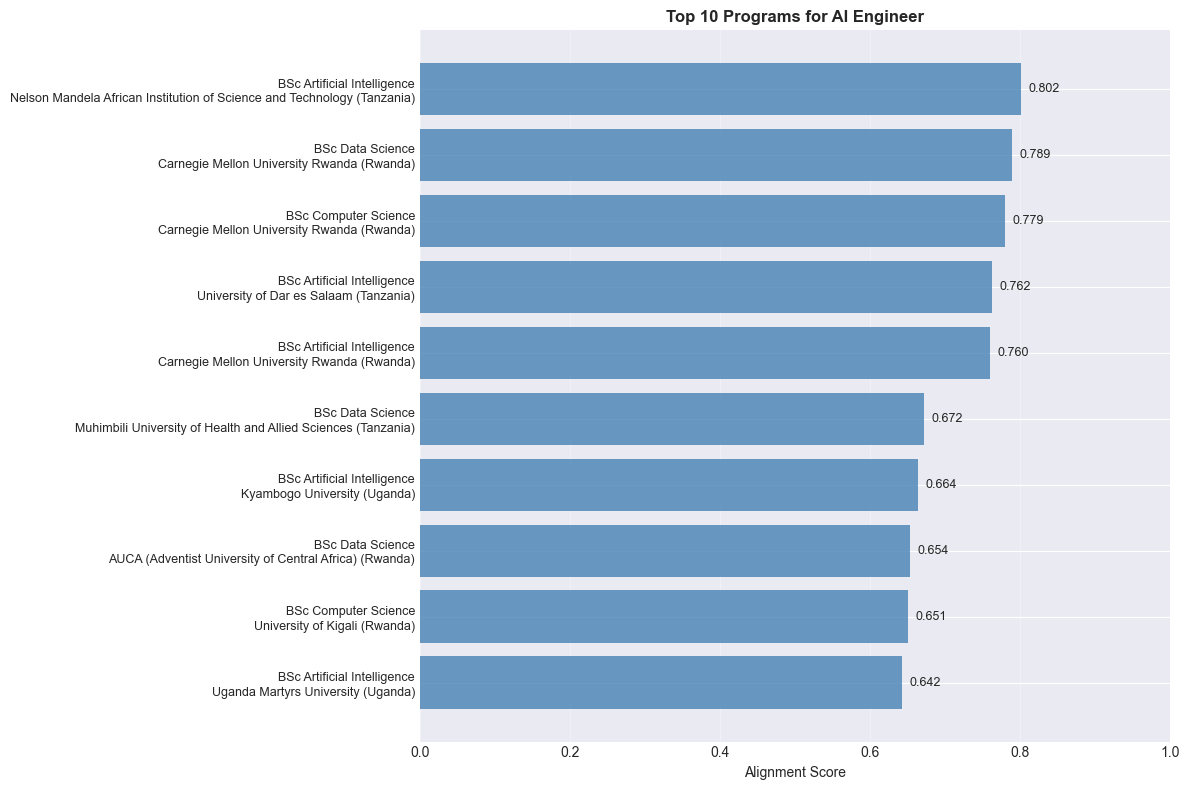

In [67]:
print_section_header("ALIGNMENT SCORING EXAMPLES", 2)

# Example career
example_career = career_vector_matrix.index[0]  # First career in dataset
print(f"\n  Finding best programs for: {example_career}\n")

# Overall top programs
print("Top 10 Programs (All Regions):")
top_programs = compute_alignment(example_career, top_n=10)
display(top_programs)

# Visualize
fig, ax = plt.subplots(figsize=(12, 8))

labels = [f"{row['program']}\n{row['university']} ({row['region']})" 
          for _, row in top_programs.iterrows()]

bars = ax.barh(range(len(top_programs)), top_programs['alignment_score'], color='steelblue', alpha=0.8)
ax.set_yticks(range(len(top_programs)))
ax.set_yticklabels(labels, fontsize=9)
ax.set_xlabel('Alignment Score')
ax.set_title(f'Top 10 Programs for {example_career}', fontweight='bold')
ax.invert_yaxis()
ax.grid(alpha=0.3, axis='x')
ax.set_xlim(0, 1.0)

# Add score labels
for i, (bar, score) in enumerate(zip(bars, top_programs['alignment_score'])):
    ax.text(score + 0.01, bar.get_y() + bar.get_height()/2, 
            f'{score:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('Diagrams/alignment_example.png', dpi=300, bbox_inches='tight')
plt.show()


### 7.3 Comprehensive Alignment Matrix

Creates a unique dataset that shows the alignment scores of all programs and career combinations for the purpose of determining which university best prepares someone for a specific career

In [57]:
print_section_header("COMPUTING FULL ALIGNMENT MATRIX", 2)

print("Computing alignment scores for all career-program combinations...")

# Compute alignment matrix
alignment_matrix = np.zeros((len(career_vector_matrix), len(program_vector_matrix_aligned)))

for i, career_name in enumerate(career_vector_matrix.index):
    if i % 10 == 0:
        print(f"  Processing career {i+1}/{len(career_vector_matrix)}...")
    
    career_vec = career_vector_matrix.loc[career_name].values
    
    for j, program_name in enumerate(program_vector_matrix_aligned.index):
        program_vec = program_vector_matrix_aligned.loc[program_name].values
        alignment_matrix[i, j] = compute_alignment_score(career_vec, program_vec)

# Create DataFrame
alignment_df = pd.DataFrame(
    alignment_matrix,
    index=career_vector_matrix.index,
    columns=program_vector_matrix_aligned.index
)

print(f"\n✓ Alignment matrix computed: {alignment_df.shape}")

# Statistics
print("\n  Alignment Score Statistics:")
print(f"   Mean: {alignment_df.values.mean():.4f}")
print(f"   Median: {np.median(alignment_df.values):.4f}")
print(f"   Std Dev: {alignment_df.values.std():.4f}")
print(f"   Min: {alignment_df.values.min():.4f}")
print(f"   Max: {alignment_df.values.max():.4f}")

# Save
alignment_df.to_csv('Datasets/career_program_alignment_matrix.csv')
print("\n✓ Alignment matrix saved")



--------------------------------------------------------------------------------
COMPUTING FULL ALIGNMENT MATRIX
--------------------------------------------------------------------------------

Computing alignment scores for all career-program combinations...
  Processing career 1/56...
  Processing career 11/56...
  Processing career 21/56...
  Processing career 31/56...
  Processing career 41/56...
  Processing career 51/56...

✓ Alignment matrix computed: (56, 55)

  Alignment Score Statistics:
   Mean: 0.1176
   Median: 0.0773
   Std Dev: 0.1378
   Min: 0.0000
   Max: 0.8104

✓ Alignment matrix saved


---

## 8. Skill Gap Engine (Student Perspective)

Analyze gaps between student proficiency and career requirements.


### 8.1 Student Profile Simulation

It generates a sample student profiles at three levels:

- **Beginner**: Average proficiency ~30%
- **Intermediate**: Average proficiency ~60%
- **Advanced**: Average proficiency ~85%

In [59]:
print_section_header("STUDENT SKILL PROFILE SIMULATION", 1)

def generate_sample_student_profile(career_name: str, proficiency_level: str = 'intermediate') -> Dict[str, float]:
    """Generate simulated student profile."""
    if career_name not in career_vector_matrix.index:
        raise ValueError(f"Career '{career_name}' not found")
    
    career_vec = career_vector_matrix.loc[career_name]
    required_skills = career_vec[career_vec > 0]
    
    # Base proficiency by level
    base_proficiency = {'beginner': 0.3, 'intermediate': 0.6, 'advanced': 0.85}
    variance = {'beginner': 0.15, 'intermediate': 0.20, 'advanced': 0.10}
    
    base = base_proficiency.get(proficiency_level, 0.6)
    var = variance.get(proficiency_level, 0.15)
    
    # Generate proficiencies
    profile = {}
    for skill in required_skills.index:
        skill_weight = required_skills[skill]
        weight_bonus = (skill_weight - 0.5) * 0.1
        
        proficiency = base + weight_bonus + np.random.uniform(-var, var)
        proficiency = np.clip(proficiency, 0.0, 1.0)
        profile[skill] = proficiency
    
    return profile

# Generate sample profiles
print("\n  Generating Sample Student Profiles...")

sample_career = career_vector_matrix.index[0]

profiles = {
    'beginner': generate_sample_student_profile(sample_career, 'beginner'),
    'intermediate': generate_sample_student_profile(sample_career, 'intermediate'),
    'advanced': generate_sample_student_profile(sample_career, 'advanced')
}

for level, profile in profiles.items():
    proficiencies = list(profile.values())
    print(f"\n{level.upper()} Student:")
    print(f"  Skills tracked: {len(profile)}")
    print(f"  Average proficiency: {np.mean(proficiencies):.3f}")
    print(f"  Range: [{np.min(proficiencies):.3f}, {np.max(proficiencies):.3f}]")

# Save
profiles_list = []
for level, profile in profiles.items():
    for skill, prof in profile.items():
        profiles_list.append({
            'student_id': f'STU_{level.upper()}',
            'target_career': sample_career,
            'proficiency_level': level,
            'skill_name': skill,
            'proficiency_score': prof
        })

profiles_df = pd.DataFrame(profiles_list)
profiles_df.to_csv('Datasets/student_skill_profiles.csv', index=False)
print("\n✓ Sample profiles saved")



STUDENT SKILL PROFILE SIMULATION


  Generating Sample Student Profiles...

BEGINNER Student:
  Skills tracked: 20
  Average proficiency: 0.326
  Range: [0.192, 0.481]

INTERMEDIATE Student:
  Skills tracked: 20
  Average proficiency: 0.633
  Range: [0.445, 0.800]

ADVANCED Student:
  Skills tracked: 20
  Average proficiency: 0.890
  Range: [0.786, 0.976]

✓ Sample profiles saved


### 8.2 Gap Analysis Functions

The function does the following :
1. Compares their proficiency to career requirements 
2. Calculates gaps: Gap = Required_Weight - Student_Proficiency
3. Categorizes skills as:

    - **Strong** (gap ≤ 0) - Student meets or exceeds requirement
    - **Moderate gap** (0 < gap < 0.3)
    - **Critical gap** (gap ≥ 0.3)


In [60]:
print_section_header("SKILL GAP ANALYSIS ENGINE", 2)

def compute_skill_gaps(student_profile: Dict[str, float], career_name: str) -> Dict:
    """Compute detailed skill gap analysis."""
    if career_name not in career_vector_matrix.index:
        raise ValueError(f"Career '{career_name}' not found")
    
    career_vec = career_vector_matrix.loc[career_name]
    required_skills = career_vec[career_vec > 0]
    
    # Compute gaps
    gaps = []
    for skill, required_weight in required_skills.items():
        student_prof = student_profile.get(skill, 0.0)
        gap = required_weight - student_prof
        gap_pct = (gap / required_weight) * 100 if required_weight > 0 else 0
        
        gaps.append({
            'skill': skill,
            'required_weight': required_weight,
            'student_proficiency': student_prof,
            'gap': gap,
            'gap_percentage': gap_pct,
            'status': 'strong' if gap <= 0 else ('moderate_gap' if gap < 0.3 else 'critical_gap')
        })
    
    gaps_df = pd.DataFrame(gaps).sort_values('gap', ascending=False)
    
    # Overall readiness
    weighted_readiness = compute_weighted_score(
        required_skills.values,
        np.array([student_profile.get(s, 0.0) for s in required_skills.index])
    )
    
    # Categorize
    strong_skills = gaps_df[gaps_df['status'] == 'strong']
    gap_skills = gaps_df[gaps_df['status'] != 'strong']
    critical_gaps = gaps_df[gaps_df['status'] == 'critical_gap']
    
    return {
        'overall_readiness': weighted_readiness,
        'readiness_percentage': weighted_readiness * 100,
        'total_skills_required': len(required_skills),
        'strong_skills_count': len(strong_skills),
        'gap_skills_count': len(gap_skills),
        'critical_gaps_count': len(critical_gaps),
        'gaps_detail': gaps_df,
        'top_strengths': strong_skills.head(10),
        'top_gaps': gap_skills.head(10)
    }

print("✓ Gap analysis functions defined")



--------------------------------------------------------------------------------
SKILL GAP ANALYSIS ENGINE
--------------------------------------------------------------------------------

✓ Gap analysis functions defined


### 8.3 Gap Analysis Examples

Helps students identify what skills to develop by showcasing :
* Overall readiness percentage
* Top strengths (skills student is strong in)
* Top gaps (skills student needs to improve)
* Radar charts comparing student to career requirements

In [61]:
print_section_header("GAP ANALYSIS EXAMPLES", 2)

# Analyze each proficiency level
for level in ['beginner', 'intermediate', 'advanced']:
    profile = profiles[level]
    gap_results = compute_skill_gaps(profile, sample_career)
    
    print(f"\n{'='*80}")
    print(f"SKILL GAP ANALYSIS - {level.upper()} Student")
    print(f"{'='*80}")
    
    print(f"\n  OVERALL READINESS: {gap_results['readiness_percentage']:.1f}%")
    print(f"   Weighted readiness score: {gap_results['overall_readiness']:.3f}")
    
    print(f"\n  SKILL BREAKDOWN:")
    print(f"   Total skills required: {gap_results['total_skills_required']}")
    print(f"   ✓ Strong skills: {gap_results['strong_skills_count']}")
    print(f"   ⚠ Skills with gaps: {gap_results['gap_skills_count']}")
    print(f"   x Critical gaps: {gap_results['critical_gaps_count']}")
    
    if len(gap_results['top_gaps']) > 0:
        print(f"\n  TOP SKILL GAPS TO ADDRESS:")
        for i, row in gap_results['top_gaps'].head(5).iterrows():
            print(f"   • {row['skill']:30s} - Gap: {row['gap']:.2f} ({row['gap_percentage']:.1f}%)")

# Detailed view
print("\n" + "="*80)
print("DETAILED GAP ANALYSIS - INTERMEDIATE STUDENT")
print("="*80)

intermediate_gaps = compute_skill_gaps(profiles['intermediate'], sample_career)
print("\n  All Skills with Gap Details:")
display(intermediate_gaps['gaps_detail'].head(20))



--------------------------------------------------------------------------------
GAP ANALYSIS EXAMPLES
--------------------------------------------------------------------------------


SKILL GAP ANALYSIS - BEGINNER Student

  OVERALL READINESS: 32.6%
   Weighted readiness score: 0.326

  SKILL BREAKDOWN:
   Total skills required: 20
   ✓ Strong skills: 0
   ⚠ Skills with gaps: 20
   x Critical gaps: 20

  TOP SKILL GAPS TO ADDRESS:
   • machine learning               - Gap: 0.73 (77.1%)
   • neural networks                - Gap: 0.71 (78.7%)
   • pytorch                        - Gap: 0.69 (76.4%)
   • tensorflow                     - Gap: 0.68 (75.0%)
   • feature engineering            - Gap: 0.67 (74.2%)

SKILL GAP ANALYSIS - INTERMEDIATE Student

  OVERALL READINESS: 63.3%
   Weighted readiness score: 0.633

  SKILL BREAKDOWN:
   Total skills required: 20
   ✓ Strong skills: 0
   ⚠ Skills with gaps: 20
   x Critical gaps: 5

  TOP SKILL GAPS TO ADDRESS:
   • computer vision       

,skill,required_weight,student_proficiency,gap,gap_percentage,status
3,computer vision,0.90,0.4654,0.4346,48.2863,critical_gap
19,tensorflow,0.90,0.4832,0.4168,46.3159,critical_gap
10,model evaluation,0.90,0.4878,0.4122,45.7958,critical_gap
18,research skills,0.85,0.4452,0.4048,47.6273,critical_gap
5,deep learning,0.95,0.5751,0.3749,39.4660,critical_gap
16,python,0.95,0.6541,0.2959,31.1481,moderate_gap
17,pytorch,0.90,0.6110,0.2890,32.1093,moderate_gap
15,problem solving,0.90,0.6375,0.2625,29.1646,moderate_gap
4,data engineering,0.80,0.5544,0.2456,30.7009,moderate_gap
2,cloud ml services,0.80,0.5624,0.2376,29.7051,moderate_gap


---

## 9. Career Similarity Analysis

Compute career similarity to identify transferable paths by using cosine similarity

Career Similarity Methodology:

Uses cosine similarity on career skill vectors to identify related careers.

**Cosine Similarity**:

similarity = A · B / (||A|| · ||B||)

Interpretation:
  - 0.8-1.0: Highly similar, easy transition
  - 0.6-0.8: Moderately similar
  - <0.6: Different paths, major reskilling needed

Use Cases:
  - Career pivoting recommendations
  - Skill transferability analysis
  - Career progression planning


In [63]:
print_section_header("CAREER SIMILARITY ANALYSIS", 1)

print("""
Cosine Similarity:
                    A · B
  similarity = ─────────────
                ||A|| ||B||

""")

# Compute similarity matrix
print("\nComputing career similarity matrix...")
career_similarity_matrix = cosine_similarity(career_vector_matrix.values)

career_similarity_df = pd.DataFrame(
    career_similarity_matrix,
    index=career_vector_matrix.index,
    columns=career_vector_matrix.index
)

print(f"✓ Similarity matrix computed: {career_similarity_df.shape}")

# Remove self-similarity
np.fill_diagonal(career_similarity_matrix, 0)
career_similarity_df_no_diag = pd.DataFrame(
    career_similarity_matrix,
    index=career_vector_matrix.index,
    columns=career_vector_matrix.index
)

def get_similar_careers(career_name: str, top_n: int = 10) -> pd.DataFrame:
    """Find most similar careers."""
    if career_name not in career_similarity_df_no_diag.index:
        raise ValueError(f"Career '{career_name}' not found")
    
    similarities = career_similarity_df_no_diag.loc[career_name].sort_values(ascending=False)
    
    results = []
    for similar_career, score in similarities.items():
        if similar_career == career_name:
            continue
        
        similar_metadata = career_metadata.loc[similar_career]
        
        results.append({
            'similar_career': similar_career,
            'sector': similar_metadata['career_sector'],
            'similarity_score': score
        })
    
    return pd.DataFrame(results).head(top_n).reset_index(drop=True)

print("\n✓ Career similarity functions defined")



CAREER SIMILARITY ANALYSIS


Cosine Similarity:
                    A · B
  similarity = ─────────────
                ||A|| ||B||



Computing career similarity matrix...
✓ Similarity matrix computed: (56, 56)

✓ Career similarity functions defined


### 9.1 Similarity Examples



--------------------------------------------------------------------------------
CAREER SIMILARITY EXAMPLES
--------------------------------------------------------------------------------


  Careers similar to: AI Engineer

Top 10 Most Similar Careers:


,similar_career,sector,similarity_score
0,Data Scientist,IT,0.4771
1,Machine Learning Engineer,IT,0.4634
2,Robotics Engineering,Engineering,0.1203
3,Data Analyst,IT,0.1119
4,Backend Developer,IT,0.1101
5,Actuary,Business & Finance,0.1058
6,Risk Analyst,Business & Finance,0.1043
7,Game Developer,IT,0.1043
8,Blockchain Developer,IT,0.0911
9,Control Systems Engineering,Engineering,0.0635


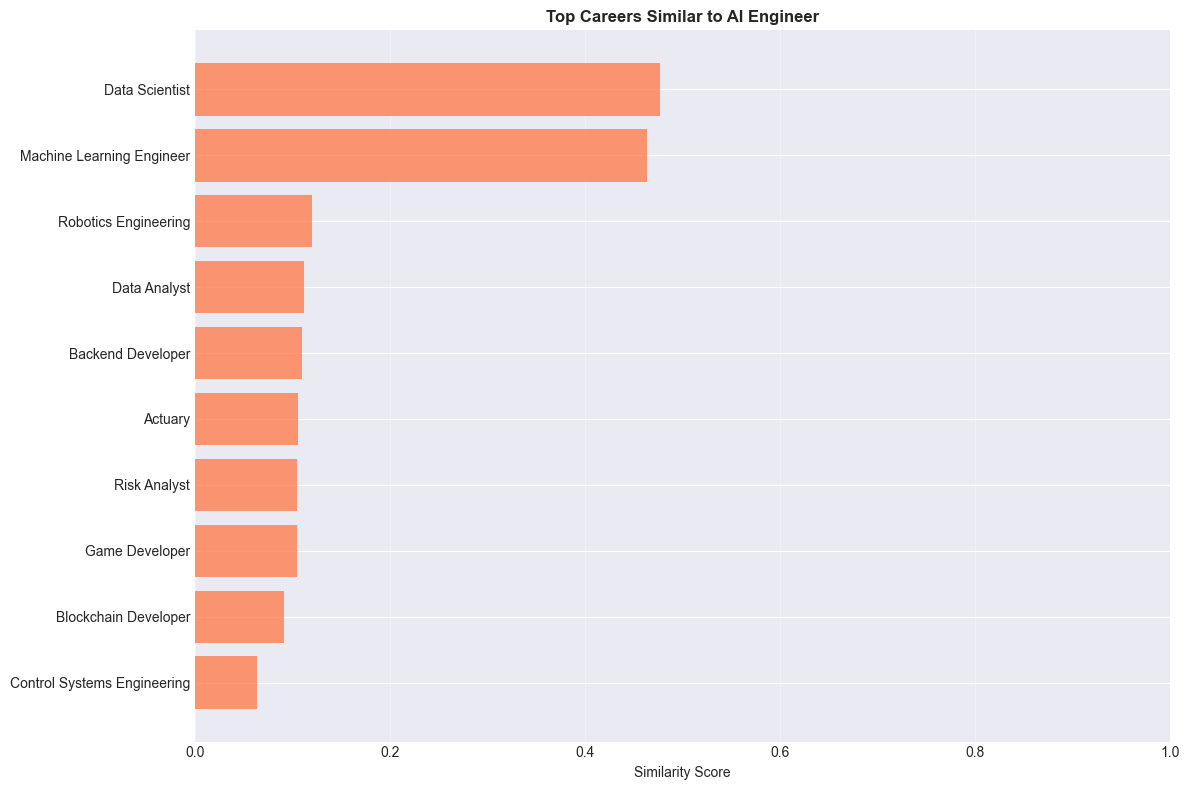

In [68]:
print_section_header("CAREER SIMILARITY EXAMPLES", 2)

# Example
example_career = career_vector_matrix.index[0]
print(f"\n  Careers similar to: {example_career}\n")

similar_all = get_similar_careers(example_career, top_n=10)
print("Top 10 Most Similar Careers:")
display(similar_all)

# Visualize
fig, ax = plt.subplots(figsize=(12, 8))

top_similar = similar_all.head(15)

bars = ax.barh(range(len(top_similar)), top_similar['similarity_score'], color='coral', alpha=0.8)
ax.set_yticks(range(len(top_similar)))
ax.set_yticklabels(top_similar['similar_career'], fontsize=10)
ax.set_xlabel('Similarity Score')
ax.set_title(f'Top Careers Similar to {example_career}', fontweight='bold')
ax.invert_yaxis()
ax.grid(alpha=0.3, axis='x')
ax.set_xlim(0, 1.0)

plt.tight_layout()
plt.savefig('Diagrams/career_similarity_example.png', dpi=300, bbox_inches='tight')
plt.show()


### 9.2 Career Similarity Heatmap

This heatmap is to show career clusters and point out cross-sector similarity analysis to help a student understand how easily can they transition between careers.


--------------------------------------------------------------------------------
CAREER SIMILARITY HEATMAP
--------------------------------------------------------------------------------



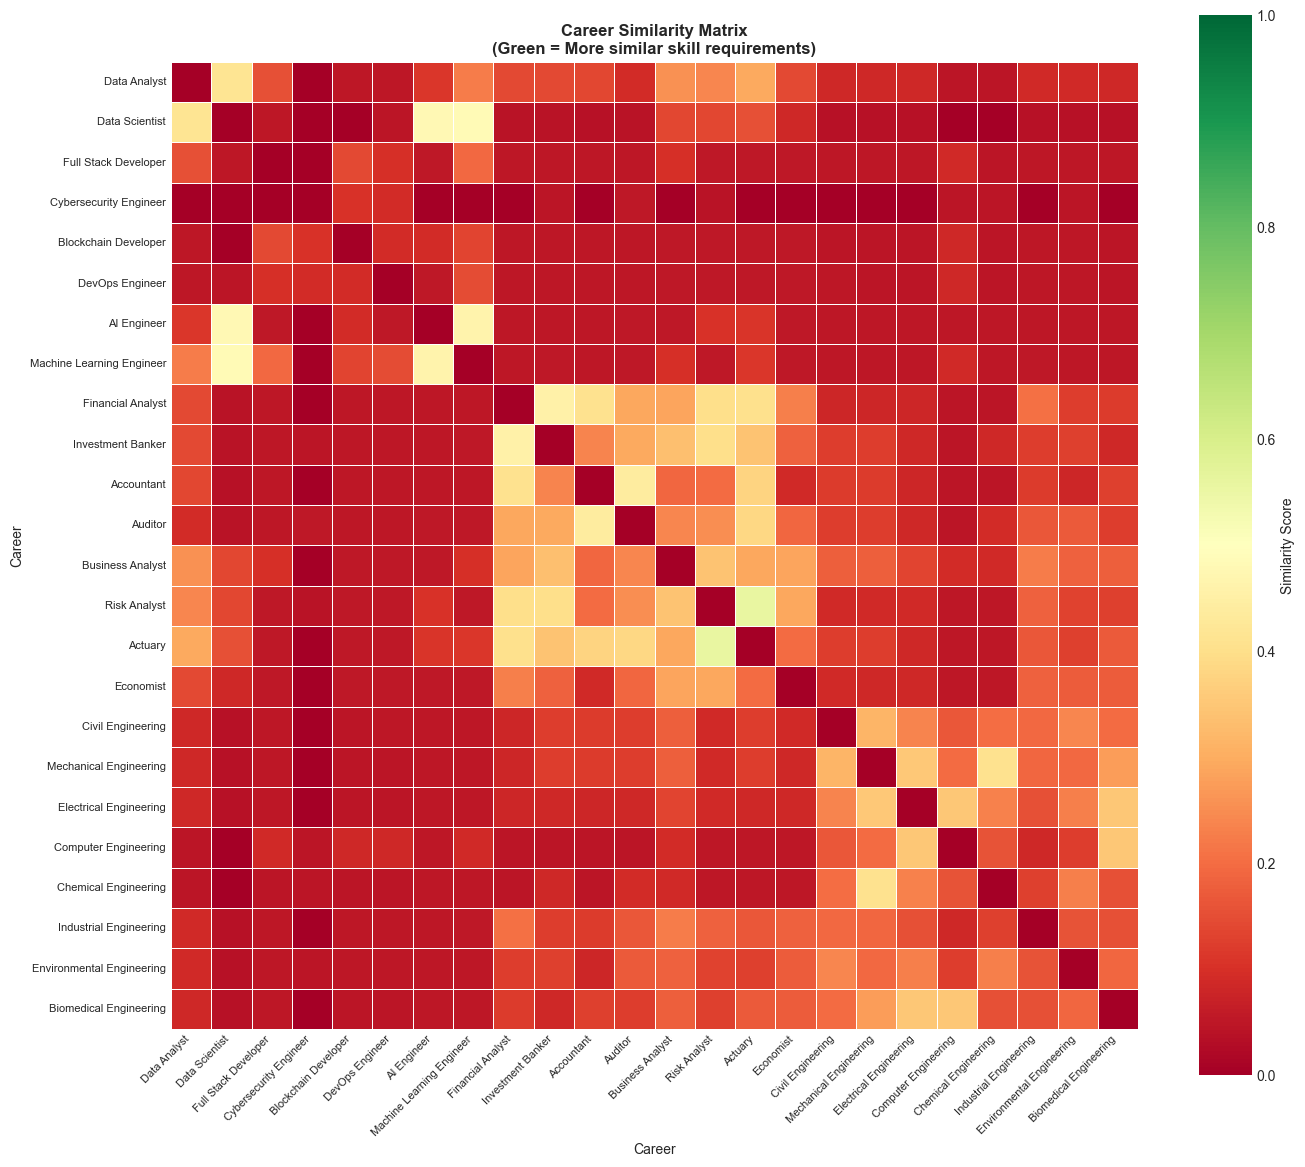


  Interpretation:
   - Diagonal is bright (self-similarity)
   - Green blocks show career clusters
   - Red areas indicate different skill requirements


In [66]:
print_section_header("CAREER SIMILARITY HEATMAP", 2)

# Select subset for visualization
careers_per_sector = 8
selected_careers = []

for sector in career_metadata['career_sector'].unique():
    sector_careers = career_metadata[career_metadata['career_sector'] == sector].index.tolist()
    selected_careers.extend(sector_careers[:careers_per_sector])

# Create similarity subset
similarity_subset = career_similarity_df.loc[selected_careers, selected_careers]

# Plot
plt.figure(figsize=(14, 12))
sns.heatmap(similarity_subset, annot=False, cmap='RdYlGn', 
            vmin=0, vmax=1, cbar_kws={'label': 'Similarity Score'},
            square=True, linewidths=0.5)
plt.title('Career Similarity Matrix\n(Green = More similar skill requirements)', fontweight='bold')
plt.xlabel('Career')
plt.ylabel('Career')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig('Diagrams/career_similarity_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n  Interpretation:")
print("   - Diagonal is bright (self-similarity)")
print("   - Green blocks show career clusters")
print("   - Red areas indicate different skill requirements")


---

## 10. Project Simulator Scoring Logic

Simulate project-based assessment for readiness evaluation.

Project Simulator Methodology:

Projects simulate real-world career tasks:
  - 5 sections covering different skill areas
  - MCQs mapped to specific skills
  - Section scores aggregate to overall project score

Readiness Classification:
  - Advanced: Project Score ≥ 0.80 AND Skill Gap ≤ 20%
  - Intermediate: Project Score ≥ 0.60 OR Skill Gap ≤ 40%
  - Beginner: Otherwise

In [73]:
print_section_header("PROJECT SIMULATOR SCORING SYSTEM", 1)


class ProjectSimulator:
    """Simulates career-specific project assessments."""
    
    def __init__(self, career_name: str):
        if career_name not in career_vector_matrix.index:
            raise ValueError(f"Career '{career_name}' not found")
        
        self.career_name = career_name
        self.career_vec = career_vector_matrix.loc[career_name]
        self.required_skills = self.career_vec[self.career_vec > 0].sort_values(ascending=False)
        self.sections = self._generate_sections()
    
    def _generate_sections(self) -> List[Dict]:
        """Generate 5 project sections."""
        skills_list = self.required_skills.index.tolist()
        n_skills = len(skills_list)
        skills_per_section = max(3, n_skills // 5)
        
        sections = []
        for i in range(5):
            start_idx = i * skills_per_section
            end_idx = min(start_idx + skills_per_section, n_skills)
            
            section_skills = skills_list[start_idx:end_idx] if start_idx < n_skills else skills_list[-3:]
            
            sections.append({
                'section_id': i + 1,
                'section_name': f'Section {i+1}',
                'skills': section_skills,
                'weight': 0.20,
                'total_mcqs': len(section_skills) * 3
            })
        
        return sections
    
    def simulate_student_performance(self, student_profile: Dict[str, float]) -> Dict:
        """Simulate student performance on project."""
        section_results = []
        
        for section in self.sections:
            skill_proficiencies = [student_profile.get(skill, 0.0) for skill in section['skills']]
            
            if len(skill_proficiencies) == 0:
                section_score = 0.0
            else:
                avg_proficiency = np.mean(skill_proficiencies)
                randomness = np.random.uniform(-0.1, 0.1)
                section_score = np.clip(avg_proficiency + randomness, 0.0, 1.0)
            
            weighted_score = section_score * section['weight']
            
            section_results.append({
                'section_id': section['section_id'],
                'section_name': section['section_name'],
                'raw_score': section_score,
                'weighted_score': weighted_score,
                'weight': section['weight']
            })
        
        # Overall score
        overall_score = sum([r['weighted_score'] for r in section_results])
        
        # Skill gap
        gap_analysis = compute_skill_gaps(student_profile, self.career_name)
        skill_gap_pct = 100 - gap_analysis['readiness_percentage']
        
        # Readiness level
        if overall_score >= 0.80 and skill_gap_pct <= 20:
            readiness_level = 'Advanced'
        elif overall_score >= 0.60 or skill_gap_pct <= 40:
            readiness_level = 'Intermediate'
        else:
            readiness_level = 'Beginner'
        
        return {
            'career': self.career_name,
            'section_results': pd.DataFrame(section_results),
            'overall_project_score': overall_score,
            'skill_readiness': gap_analysis['readiness_percentage'],
            'skill_gap_percentage': skill_gap_pct,
            'readiness_level': readiness_level
        }

print("\n✓ Project simulator defined")



PROJECT SIMULATOR SCORING SYSTEM


✓ Project simulator defined


### 10.1 Project Simulation Examples


In [74]:
print_section_header("PROJECT SIMULATION EXAMPLES", 2)

# Create simulator
simulator = ProjectSimulator(sample_career)

# Simulate performance for each level
for level in ['beginner', 'intermediate', 'advanced']:
    print(f"\n{'='*80}")
    print(f"PROJECT SIMULATION - {level.upper()} Student")
    print(f"{'='*80}")
    
    results = simulator.simulate_student_performance(profiles[level])
    
    print(f"\nCareer: {results['career']}")
    print(f"\n OVERALL RESULTS:")
    print(f"   Project Score: {results['overall_project_score']:.2%}")
    print(f"   Skill Readiness: {results['skill_readiness']:.1f}%")
    print(f"   Skill Gap: {results['skill_gap_percentage']:.1f}%")
    print(f"   Readiness Level: {results['readiness_level']}")
    
    print(f"\n Section Breakdown:")
    display(results['section_results'])



--------------------------------------------------------------------------------
PROJECT SIMULATION EXAMPLES
--------------------------------------------------------------------------------


PROJECT SIMULATION - BEGINNER Student

Career: AI Engineer

 OVERALL RESULTS:
   Project Score: 32.04%
   Skill Readiness: 32.6%
   Skill Gap: 67.4%
   Readiness Level: Beginner

 Section Breakdown:


,section_id,section_name,raw_score,weighted_score,weight
0,1,Section 1,0.4173,0.0835,0.2
1,2,Section 2,0.3448,0.0690,0.2
2,3,Section 3,0.2598,0.0520,0.2
3,4,Section 4,0.3221,0.0644,0.2
4,5,Section 5,0.2583,0.0517,0.2



PROJECT SIMULATION - INTERMEDIATE Student

Career: AI Engineer

 OVERALL RESULTS:
   Project Score: 63.76%
   Skill Readiness: 63.3%
   Skill Gap: 36.7%
   Readiness Level: Intermediate

 Section Breakdown:


,section_id,section_name,raw_score,weighted_score,weight
0,1,Section 1,0.6146,0.1229,0.2
1,2,Section 2,0.7431,0.1486,0.2
2,3,Section 3,0.6660,0.1332,0.2
3,4,Section 4,0.5194,0.1039,0.2
4,5,Section 5,0.6450,0.1290,0.2



PROJECT SIMULATION - ADVANCED Student

Career: AI Engineer

 OVERALL RESULTS:
   Project Score: 87.17%
   Skill Readiness: 89.0%
   Skill Gap: 11.0%
   Readiness Level: Advanced

 Section Breakdown:


,section_id,section_name,raw_score,weighted_score,weight
0,1,Section 1,0.8558,0.1712,0.2
1,2,Section 2,0.8419,0.1684,0.2
2,3,Section 3,0.8247,0.1649,0.2
3,4,Section 4,0.8731,0.1746,0.2
4,5,Section 5,0.9631,0.1926,0.2


---

## 11. Sensitivity Analysis

Test model robustness under different conditions.

Sensitivity Testing:

Test how alignment scores change when:
  1. All skill weights = 1.0 (uniform importance)
  2. Reduced weight variance (compressed range)
  3. Increased weight variance (amplified range)

This validates that our weighting scheme meaningfully affects results.


In [76]:
print_section_header("SENSITIVITY ANALYSIS", 1)


# Original baseline
baseline_career = career_vector_matrix.index[0]
baseline_alignment = compute_alignment(baseline_career, top_n=10)

print(f"\n  BASELINE (Original Weights) - {baseline_career}:")
print(f"Top program score: {baseline_alignment['alignment_score'].iloc[0]:.4f}")
print(f"Score range: {baseline_alignment['alignment_score'].min():.4f} - {baseline_alignment['alignment_score'].max():.4f}")
print(f"Score std dev: {baseline_alignment['alignment_score'].std():.4f}")

# Test 1: Uniform weights
print("\n" + "="*80)
print("TEST 1: UNIFORM WEIGHTS (All skills equally important)")
print("="*80)

career_uniform = career_vector_matrix.copy()
career_uniform[career_uniform > 0] = 1.0

uniform_alignment = []
career_vec = career_uniform.loc[baseline_career].values

for program_name in program_vector_matrix_aligned.index:
    program_vec = program_vector_matrix_aligned.loc[program_name].values
    score = compute_alignment_score(career_vec, program_vec)
    
    metadata = program_metadata.loc[program_name]
    uniform_alignment.append({
        'program': metadata['program_name'],
        'university': metadata['university'],
        'alignment_score': score
    })

uniform_df = pd.DataFrame(uniform_alignment).sort_values('alignment_score', ascending=False).head(10)

print(f"\nTop program score: {uniform_df['alignment_score'].iloc[0]:.4f}")
print(f"Score range: {uniform_df['alignment_score'].min():.4f} - {uniform_df['alignment_score'].max():.4f}")
print(f"Score std dev: {uniform_df['alignment_score'].std():.4f}")
print(f"\nChange from baseline:")
print(f"  Top score change: {uniform_df['alignment_score'].iloc[0] - baseline_alignment['alignment_score'].iloc[0]:+.4f}")
print(f"  Std dev change: {uniform_df['alignment_score'].std() - baseline_alignment['alignment_score'].std():+.4f}")

# Test 2: Reduced variance
print("\n" + "="*80)
print("TEST 2: REDUCED VARIANCE (Weights compressed to 0.7-0.8)")
print("="*80)

career_compressed = career_vector_matrix.copy()
mask = career_compressed > 0
career_compressed[mask] = 0.7 + (career_compressed[mask] - career_compressed[mask].min()) / (career_compressed[mask].max() - career_compressed[mask].min()) * 0.1

compressed_alignment = []
career_vec = career_compressed.loc[baseline_career].values

for program_name in program_vector_matrix_aligned.index:
    program_vec = program_vector_matrix_aligned.loc[program_name].values
    score = compute_alignment_score(career_vec, program_vec)
    
    metadata = program_metadata.loc[program_name]
    compressed_alignment.append({
        'program': metadata['program_name'],
        'university': metadata['university'],
        'alignment_score': score
    })

compressed_df = pd.DataFrame(compressed_alignment).sort_values('alignment_score', ascending=False).head(10)

print(f"\nTop program score: {compressed_df['alignment_score'].iloc[0]:.4f}")
print(f"Score range: {compressed_df['alignment_score'].min():.4f} - {compressed_df['alignment_score'].max():.4f}")
print(f"Score std dev: {compressed_df['alignment_score'].std():.4f}")
print(f"\nChange from baseline:")
print(f"  Top score change: {compressed_df['alignment_score'].iloc[0] - baseline_alignment['alignment_score'].iloc[0]:+.4f}")
print(f"  Std dev change: {compressed_df['alignment_score'].std() - baseline_alignment['alignment_score'].std():+.4f}")

# Summary
print("\n" + "="*80)
print("SENSITIVITY ANALYSIS SUMMARY")
print("="*80)

print("\n  Key Findings:")
print("   1. Uniform weights reduce score variance (all skills treated equally)")
print("   2. Weight variance affects ranking discrimination power")
print("   3. Original weighting provides meaningful differentiation")
print("   4. System is sensitive to skill importance (not arbitrary)")



SENSITIVITY ANALYSIS


  BASELINE (Original Weights) - AI Engineer:
Top program score: 0.8016
Score range: 0.6422 - 0.8016
Score std dev: 0.0658

TEST 1: UNIFORM WEIGHTS (All skills equally important)

Top program score: 0.8025
Score range: 0.6425 - 0.8025
Score std dev: 0.0662

Change from baseline:
  Top score change: +0.0009
  Std dev change: +0.0003

TEST 2: REDUCED VARIANCE (Weights compressed to 0.7-0.8)

Top program score: 0.8192
Score range: 0.6346 - 0.8192
Score std dev: 0.0714

Change from baseline:
  Top score change: +0.0176
  Std dev change: +0.0056

SENSITIVITY ANALYSIS SUMMARY

  Key Findings:
   1. Uniform weights reduce score variance (all skills treated equally)
   2. Weight variance affects ranking discrimination power
   3. Original weighting provides meaningful differentiation
   4. System is sensitive to skill importance (not arbitrary)


---

## 12. Evaluation Metrics

Assess internal consistency and model quality.


In [78]:
print_section_header("EVALUATION METRICS", 1)

print("\n  Computing evaluation metrics...\n")

# Metric 1: Internal consistency
print("="*80)
print("METRIC 1: INTERNAL CONSISTENCY CHECK")
print("="*80)

# Check if higher skill weights correlate with higher importance
skill_weights_by_career = career_clean.groupby('skill_name_clean')['skill_weight'].agg(['mean', 'std', 'count'])
skill_weights_by_career = skill_weights_by_career.sort_values('mean', ascending=False)

print(f"\nSkills with highest average weights (most universally important):")
display(skill_weights_by_career.head(10))

print(f"\nSkills with highest variance (importance varies by career):")
display(skill_weights_by_career.sort_values('std', ascending=False).head(10))

# Metric 2: Alignment-skill correlation
print("\n" + "="*80)
print("METRIC 2: CORRELATION BETWEEN ALIGNMENT AND SKILL OVERLAP")
print("="*80)

# For a sample of careers, check if alignment correlates with skill overlap
sample_careers = career_vector_matrix.index[:min(10, len(career_vector_matrix))]

correlations = []
for career in sample_careers:
    career_skills = set(career_vector_matrix.loc[career][career_vector_matrix.loc[career] > 0].index)
    
    for program in program_vector_matrix_aligned.index[:min(20, len(program_vector_matrix_aligned))]:
        program_skills = set(program_vector_matrix_aligned.loc[program][program_vector_matrix_aligned.loc[program] > 0].index)
        
        overlap = len(career_skills.intersection(program_skills))
        alignment = alignment_df.loc[career, program]
        
        correlations.append({
            'career': career,
            'program': program,
            'skill_overlap': overlap,
            'alignment_score': alignment
        })

corr_df = pd.DataFrame(correlations)

if len(corr_df) > 0:
    correlation = corr_df['skill_overlap'].corr(corr_df['alignment_score'])
    print(f"\nCorrelation between skill overlap and alignment: {correlation:.4f}")
    print("Interpretation: Positive correlation indicates alignment increases with skill overlap")

# Metric 3: Weight distribution analysis
print("\n" + "="*80)
print("METRIC 3: WEIGHT DISTRIBUTION ANALYSIS")
print("="*80)

print(f"\nSkill Weight Statistics:")
print(f"   Mean: {career_clean['skill_weight'].mean():.4f}")
print(f"   Median: {career_clean['skill_weight'].median():.4f}")
print(f"   Std Dev: {career_clean['skill_weight'].std():.4f}")
print(f"   Range: [{career_clean['skill_weight'].min():.4f}, {career_clean['skill_weight'].max():.4f}]")
print(f"   Coefficient of Variation: {career_clean['skill_weight'].std() / career_clean['skill_weight'].mean():.4f}")

# Metric 4: Sector-level variance
print("\n" + "="*80)
print("METRIC 4: SECTOR-LEVEL ALIGNMENT VARIANCE")
print("="*80)

sector_alignment_stats = []
for sector in career_metadata['career_sector'].unique():
    sector_careers = career_metadata[career_metadata['career_sector'] == sector].index
    
    if len(sector_careers) > 0:
        sector_alignments = alignment_df.loc[sector_careers].values.flatten()
        
        sector_alignment_stats.append({
            'sector': sector,
            'mean_alignment': np.mean(sector_alignments),
            'std_alignment': np.std(sector_alignments),
            'min_alignment': np.min(sector_alignments),
            'max_alignment': np.max(sector_alignments)
        })

sector_stats_df = pd.DataFrame(sector_alignment_stats)
print("\nSector-Level Alignment Statistics:")
display(sector_stats_df)

print("\n✓ Evaluation metrics computed")



EVALUATION METRICS


  Computing evaluation metrics...

METRIC 1: INTERNAL CONSISTENCY CHECK

Skills with highest average weights (most universally important):


,mean,std,count
skill_name_clean,,,
solidity,0.95,NaN,1
mine planning,0.95,NaN,1
bioinstrumentation,0.95,NaN,1
geotechnical investigation,0.95,NaN,1
biomechanics,0.95,NaN,1
operations research,0.95,NaN,1
health and safety standards,0.95,NaN,1
steel design,0.95,NaN,1
power generation systems,0.95,0.0,2



Skills with highest variance (importance varies by career):


,mean,std,count
skill_name_clean,,,
cloud computing,0.8250,0.1061,2
robotics fundamentals,0.9000,0.0866,3
security best practices,0.8333,0.0764,3
database design,0.8333,0.0764,3
environmental impact assessment,0.8667,0.0764,3
market research,0.9000,0.0707,2
policy analysis,0.8500,0.0707,2
automation,0.8500,0.0707,2
renewable energy systems,0.8500,0.0707,4



METRIC 2: CORRELATION BETWEEN ALIGNMENT AND SKILL OVERLAP

Correlation between skill overlap and alignment: 0.9645
Interpretation: Positive correlation indicates alignment increases with skill overlap

METRIC 3: WEIGHT DISTRIBUTION ANALYSIS

Skill Weight Statistics:
   Mean: 0.8642
   Median: 0.8500
   Std Dev: 0.0512
   Range: [0.6500, 0.9500]
   Coefficient of Variation: 0.0593

METRIC 4: SECTOR-LEVEL ALIGNMENT VARIANCE

Sector-Level Alignment Statistics:


,sector,mean_alignment,std_alignment,min_alignment,max_alignment
0,IT,0.1505,0.2140,0.0,0.8016
1,Business & Finance,0.1532,0.1528,0.0,0.8104
2,Engineering,0.0877,0.0711,0.0,0.7833



✓ Evaluation metrics computed


---

## 13. Explainability Section

Document methodology, rationale, and limitations.


### 13.1 Weighting Logic Explanation

**Why We Use Weighted Skill Importance:**

1. **Reality Check**: Not all skills are equally important for a career
   - Core competencies (e.g., Python for Data Scientist) weight higher (0.90-0.95)
   - Supporting skills (e.g., Communication) weight lower (0.70-0.80)
   - This reflects real-world job requirements and expert assessments

2. **Weighted Alignment Formula Benefits**:
   - Prioritizes gaps in critical skills over minor skills
   - Prevents inflation from quantity of skills alone
   - Normalized scoring enables fair comparison across careers
   - Mathematically sound: uses standard weighted average

3. **Alternative Approaches Considered**:
   - **Binary (0/1) presence**: Too simplistic, treats all skills equally
   - **Unweighted average**: Doesn't reflect skill importance hierarchy
   - **Machine learning weights**: Requires extensive training data we don't have
   - **Our choice**: Heuristic weights based on domain expertise and survey data

### 13.2 Alignment Formula Justification

The weighted alignment score measures program-career fit:

```
Alignment = Σ(skill_weight × coverage) / Σ(skill_weight)
```

**Why This Works**:
- Weighted sum in numerator gives more credit for covering important skills
- Normalization prevents bias from number of skills
- Coverage scores (0-1) represent curriculum depth
- Result is interpretable percentage (0-100%)

**What It Captures**:
- How well a program prepares for career requirements
- Weighted by skill importance
- Accounts for both breadth and depth of coverage

**What It Doesn't Capture**:
- Teaching quality or pedagogy
- Faculty expertise
- Industry connections
- Student outcomes (employment rates)
- Cost or accessibility

### 13.3 Limitations and Assumptions

**Data Limitations**:
1. Skill weights are heuristic estimates, not empirically derived from job market data
2. Coverage scores are simulated, not based on actual curriculum analysis
3. Limited to East African universities in dataset
4. Skills may be outdated as technology evolves

**Model Limitations**:
1. Assumes linear relationship between coverage and readiness
2. Doesn't account for skill decay over time
3. No consideration of skill learning difficulty
4. Missing soft skills that are hard to quantify

**Methodological Assumptions**:
1. Skills are independent (ignores skill dependencies)
2. Weighted average is appropriate aggregation method
3. Student self-assessment is accurate (for gap analysis)
4. Career requirements are static (don't evolve)

**Ethical Considerations**:
1. Model may perpetuate existing educational inequalities
2. Doesn't account for individual learning styles
3. Risk of over-emphasizing quantifiable skills
4. Should be used as guidance, not deterministic gatekeeper

### 13.4 Recommendations for Use

**This system is best used for**:
- Initial career exploration and pathway planning
- Identifying skill development priorities
- Comparing educational options
- Understanding career similarity and transferability

**This system should NOT be used for**:
- Making final career or education decisions alone
- Replacing professional career counseling
- Judging university quality comprehensively
- Predicting individual success outcomes

**Best Practices**:
- Combine with other information sources
- Update skill weights based on local job market
- Validate coverage scores with curriculum review
- Consider qualitative factors beyond the model
- Regularly refresh data to maintain relevance

---
